# **Coffee Shop Sales: Predictive Analysis**


Transaction records for Maven Roasters, a fictitious coffee shop operating out of three NYC locations. Dataset includes the transaction date, timestamp and location, along with product-level details.


## **1. Import Libraries and Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data= pd.read_excel("Coffee Shop Sales.xlsx")

## **2. Feature Engineering**
- Create a revenue per transaction variable - `transaction_value`

In [3]:
# Create a revenue variable by getting transaction_amount for each variable - multiplying transaction_qty and unit_price

data['transaction_value'] = data['transaction_qty'] * data['unit_price']
data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,transaction_value
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.0
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2


## **3: Working data**

In [4]:
daily_sales = data.groupby('transaction_date')['transaction_value'].sum().reset_index()
daily_sales.columns = ['date', 'sales']

# Set 'date' as the index for further analysis
daily_sales.set_index('date', inplace=True)

daily_sales

,sales
date,
2023-01-01,2508.20
2023-01-02,2403.35
2023-01-03,2565.00
2023-01-04,2220.10
2023-01-05,2418.85
...,...
2023-06-26,5875.90
2023-06-27,5975.65
2023-06-28,4728.90


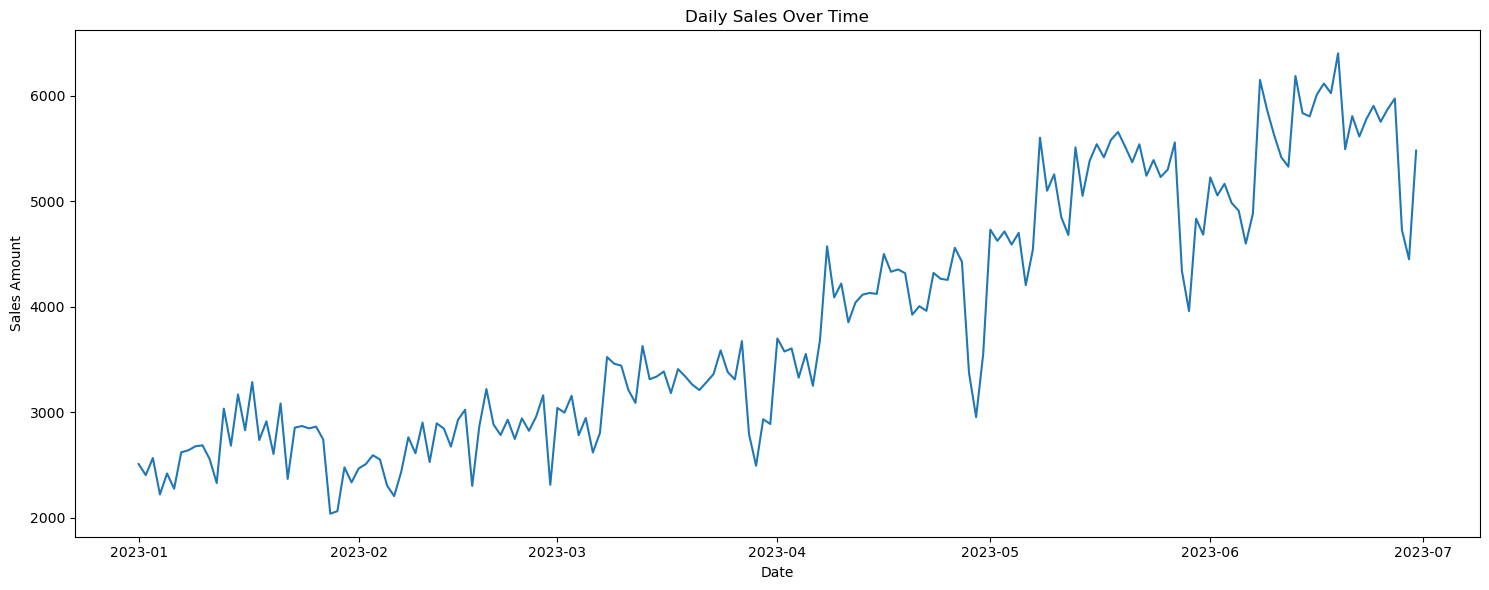

In [5]:
# Visualization of data

plt.figure(figsize=(15, 6))
sns. lineplot(data=daily_sales, x= daily_sales.index, y= daily_sales['sales'])

plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')

plt.tight_layout()
plt.show()

## **4: Stationarity Check**

In [6]:
# Perform the Augmented Dickey-Fuller (ADF) test

from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_sales['sales'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("Rejecting Null Hypothesis --> The series is stationary")
else:
    print("Not rejecting Null Hypothesis --> The series is not stationary")


ADF Statistic: -0.7085692033124111
p-value: 0.8445174174763062
Not rejecting Null Hypothesis --> The series is not stationary


## **5: Convert Non-Stationary Data to Stationary**

In [7]:
# First-order differencing: Removes linear trends

daily_sales['sales_diff'] = daily_sales['sales'] - daily_sales['sales'].shift(1)
daily_sales_diff = daily_sales.dropna()

In [8]:
# Perform the ADF test on differenced data
result_diff = adfuller(daily_sales_diff['sales_diff'])
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

if result_diff[1] <= 0.05:
    print("Rejecting Null Hypothesis --> The series is stationary")
else:
    print("Not rejecting Null Hypothesis --> The series is not stationary")

ADF Statistic (Differenced): -4.0243651429095
p-value (Differenced): 0.001288166786132084
Rejecting Null Hypothesis --> The series is stationary


#### Note: Data is stationary now. 

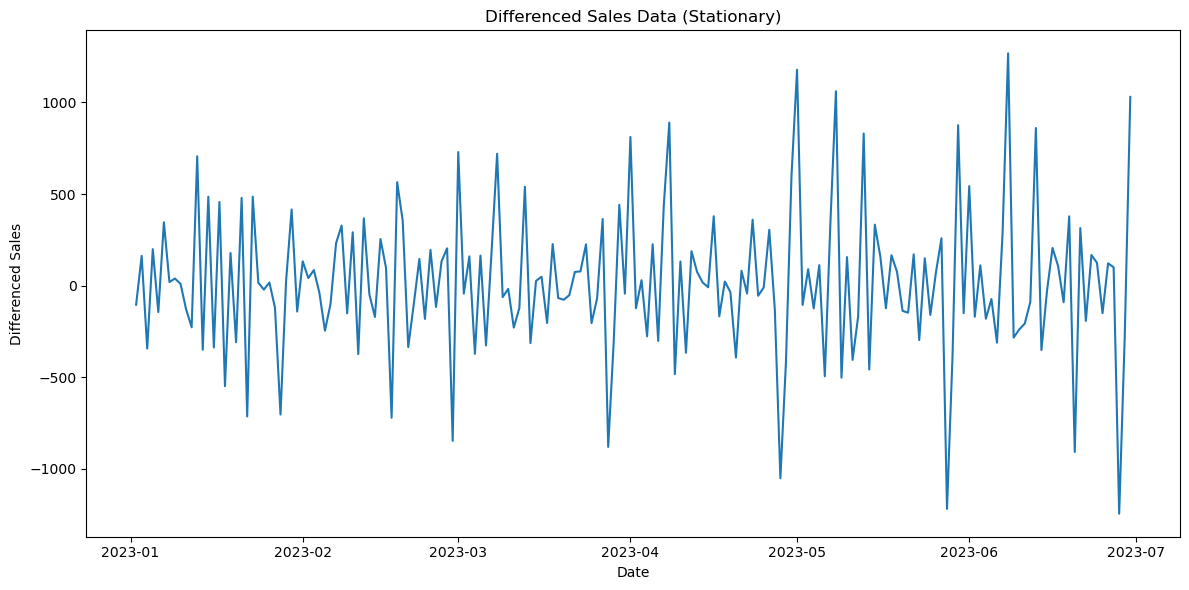

In [9]:
# Plot differenced data
plt.figure(figsize=(12, 6))

plt.plot(daily_sales_diff['sales_diff'])

plt.title('Differenced Sales Data (Stationary)')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')

plt.tight_layout()
plt.show()

## **6. Autocorrelation and Partial Autocorrelation**
- Use Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots to help determine the appropriate order of the AR (Auto-Regressive) and MA (Moving Average) components in the ARIMA model.
- ACF shows the correlation of the series with its own lagged values.
- PACF helps to identify the order of the AR term.

In [10]:
daily_sales_diff.drop(columns= 'sales', inplace=True)
daily_sales_diff

C:\Users\deshm\AppData\Local\Temp\ipykernel_2044\1348737489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_sales_diff.drop(columns= 'sales', inplace=True)


,sales_diff
date,
2023-01-02,-104.85
2023-01-03,161.65
2023-01-04,-344.90
2023-01-05,198.75
2023-01-06,-145.00
...,...
2023-06-26,121.05
2023-06-27,99.75
2023-06-28,-1246.75


#### **6.1: Autocorrelation Function (ACF)**

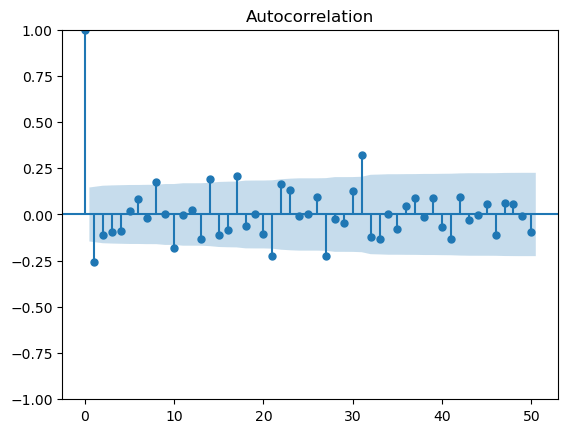

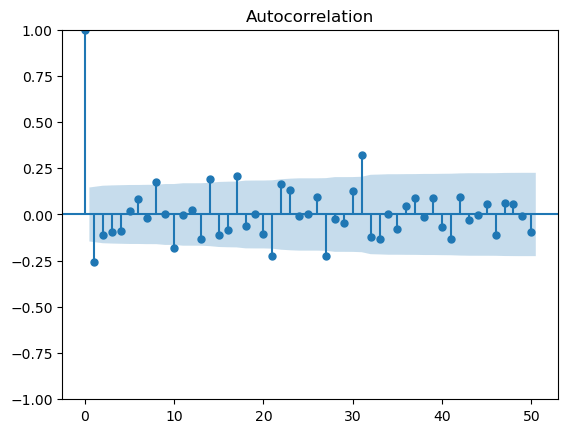

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(daily_sales_diff, lags=50)


#### **6.2: Partical Auto Correlation Function (PACF)**

- All values lie between +1 to -1
- Only partial outer correlation

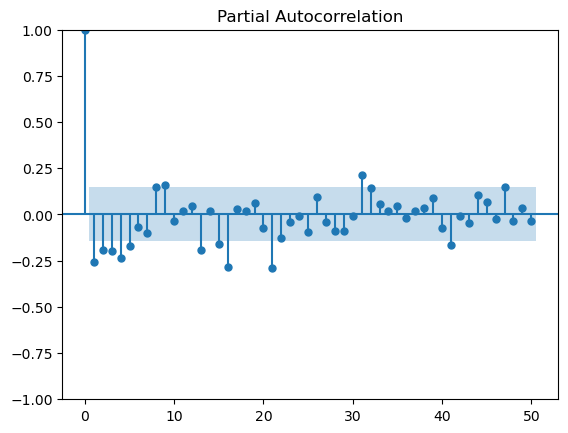

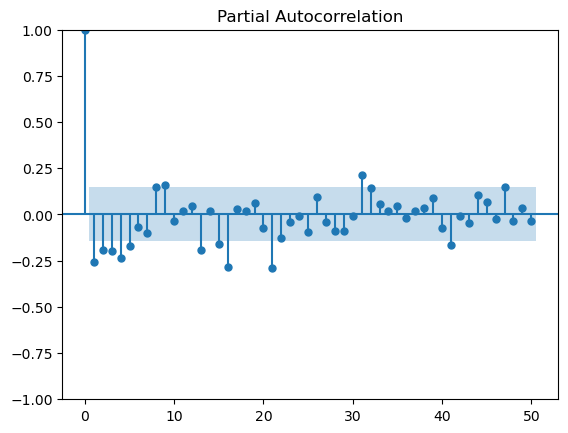

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(daily_sales_diff, lags = 50)

##### **Note:** Based on the provided ACF and PACF plots:

- Moving Average (MA) component (q): The ACF plot shows a sharp drop after lag 1 and gradual decay afterward. This suggests a possible Moving Average (MA) component with `q=1`.
- Auto-Regressive (AR) component (p): The PACF plot cuts off sharply after lag 1, which indicates a strong Auto-Regressive (AR) component with `p=1`.
- Differencing Order (d): We have already applied first-order differencing, which is common for removing trends. So, `d=1`.

Selected Parameters for ARIMA Model:
- AR (p): 1
- Differencing (d): 1
- MA (q): 1
- `The ARIMA model order would be ARIMA(1, 1, 1)`.

### **7. Build the ARIMA Model**

In [13]:
# ARIMA Model order

p= 1
q= 1
d= 1

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model
model = ARIMA(daily_sales_diff['sales_diff'], order=(p, d, q))  # Replace p, d, q with chosen values

# Fit the model
model_fit = model.fit()

c:\Users\deshm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\deshm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\deshm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             sales_diff   No. Observations:                  180
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1322.391
Date:                Thu, 19 Dec 2024   AIC                           2650.781
Time:                        19:15:54   BIC                           2660.343
Sample:                    01-02-2023   HQIC                          2654.659
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2637      0.069     -3.804      0.000      -0.400      -0.128
ma.L1         -1.0000      0.075    -13.380      0.000      -1.146      -0.854
sigma2      1.484e+05   5.04e-07   2.95e+11      0.0

### **8. Residual Diagnostics**

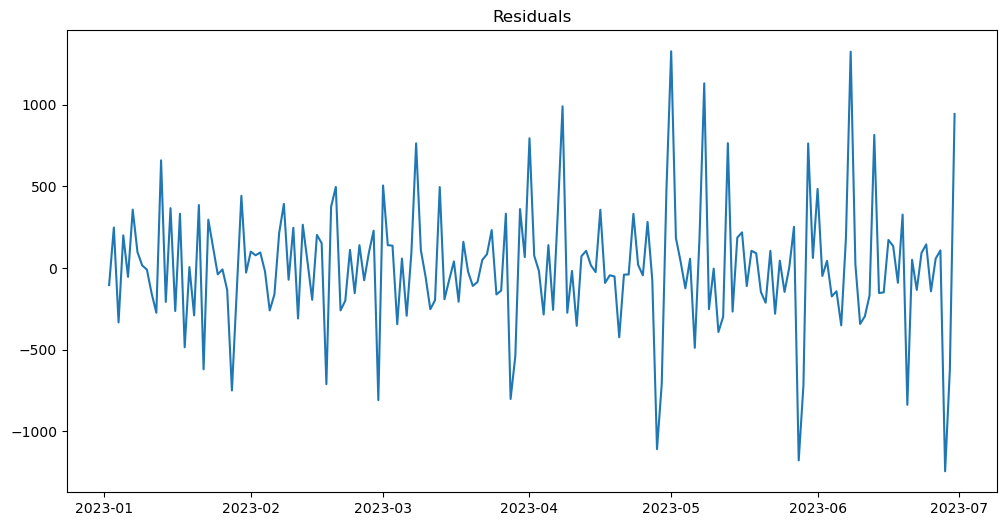

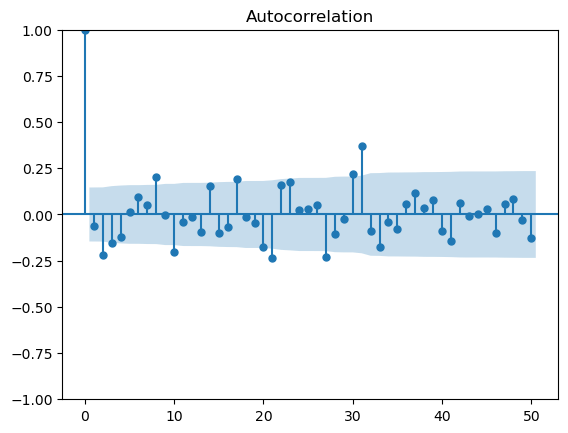

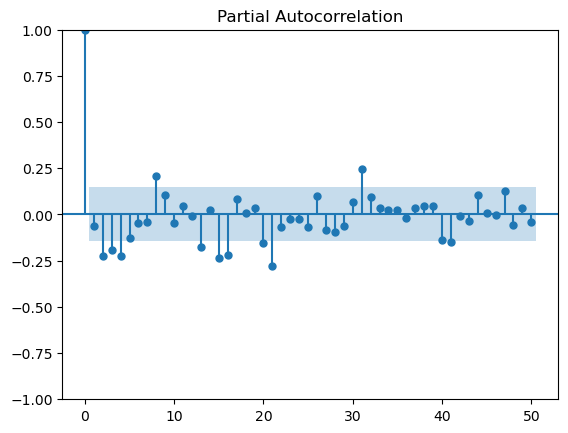

In [16]:
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=50)
plot_pacf(residuals, lags=50)
plt.show()

### **9. Forecating**

#### **9.1: Residuals**

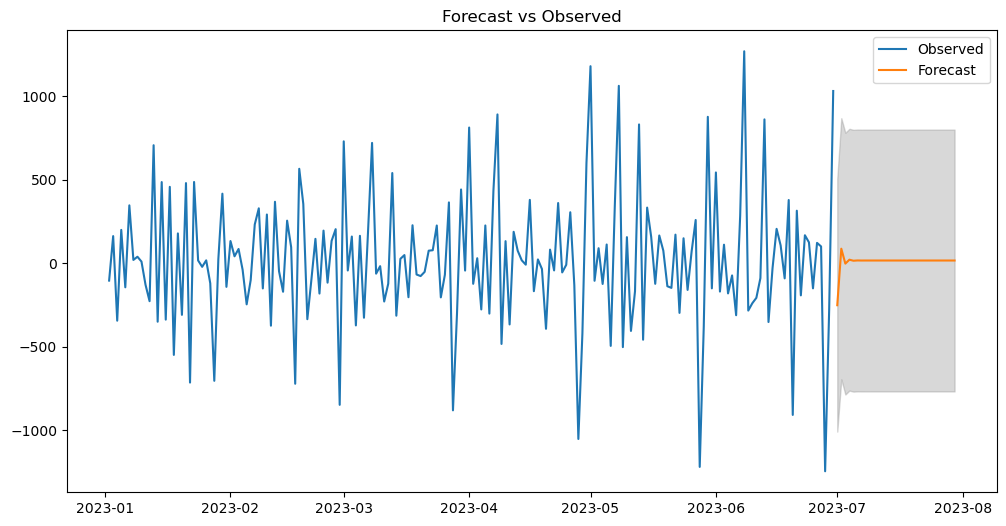

In [17]:
forecast = model_fit.get_forecast(steps=30)  # Forecast for the next 30 days
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales_diff.index, daily_sales_diff['sales_diff'], label="Observed")
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label="Forecast")
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("Forecast vs Observed")
plt.show()


### 9.2: **Plot Observed and predicted values**

C:\Users\deshm\AppData\Local\Temp\ipykernel_2044\1070645524.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_observed = daily_sales['sales'][-1]  # Last observed value in the original series


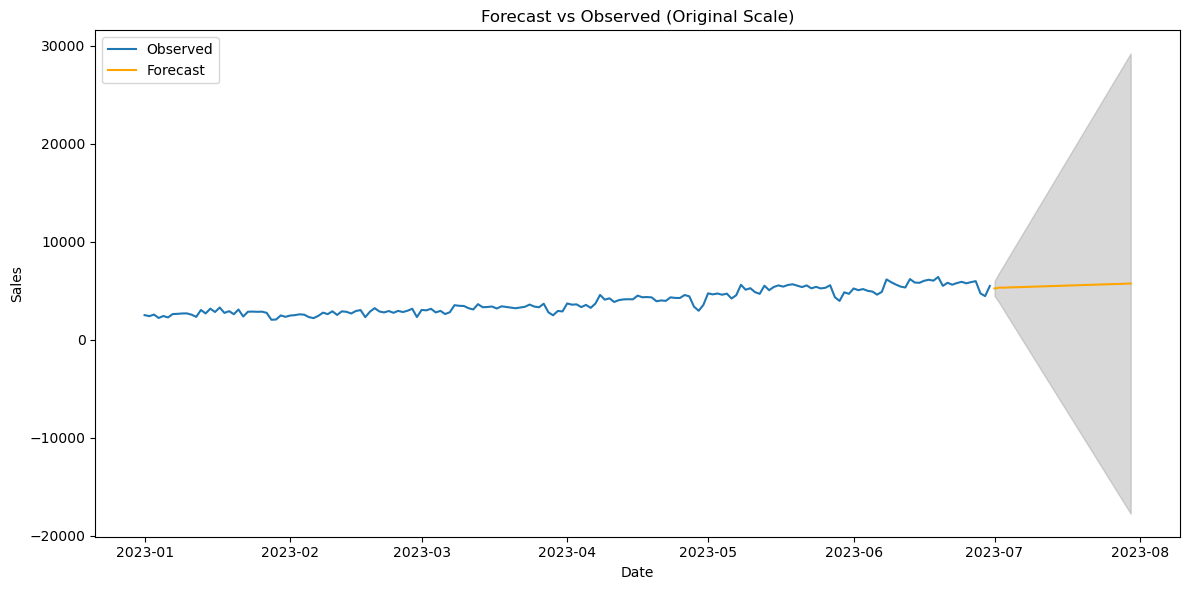

In [18]:
# Forecast for the next 30 days
forecast = model_fit.get_forecast(steps=30)
forecast_diff = forecast.predicted_mean  # These are the differenced forecasts
forecast_ci = forecast.conf_int()  # Confidence intervals

# Convert differenced forecast to original scale
last_observed = daily_sales['sales'][-1]  # Last observed value in the original series
forecast_original = forecast_diff.cumsum() + last_observed  # Undo differencing

# Plot observed and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['sales'], label="Observed")
plt.plot(forecast_original.index, forecast_original, label="Forecast", color='orange')
plt.fill_between(
    forecast_original.index, 
    forecast_ci.iloc[:, 0].cumsum() + last_observed,  # Lower CI bound on original scale
    forecast_ci.iloc[:, 1].cumsum() + last_observed,  # Upper CI bound on original scale
    color='gray', alpha=0.3
)
plt.legend()
plt.title("Forecast vs Observed (Original Scale)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

In [19]:
forecast_original

2023-07-01    5229.050972
2023-07-02    5315.111790
2023-07-03    5311.943109
2023-07-04    5332.307390
2023-07-05    5346.465200
2023-07-06    5362.259875
2023-07-07    5377.622851
2023-07-08    5393.099681
2023-07-09    5408.546484
2023-07-10    5424.001206
2023-07-11    5439.453840
2023-07-12    5454.907024
2023-07-13    5470.360063
2023-07-14    5485.813141
2023-07-15    5501.266208
2023-07-16    5516.719278
2023-07-17    5532.172347
2023-07-18    5547.625417
2023-07-19    5563.078486
2023-07-20    5578.531556
2023-07-21    5593.984625
2023-07-22    5609.437694
2023-07-23    5624.890764
2023-07-24    5640.343833
2023-07-25    5655.796903
2023-07-26    5671.249972
2023-07-27    5686.703042
2023-07-28    5702.156111
2023-07-29    5717.609180
2023-07-30    5733.062250
Freq: D, Name: predicted_mean, dtype: float64

### **9.3: Plot Predicted values along with actual values**

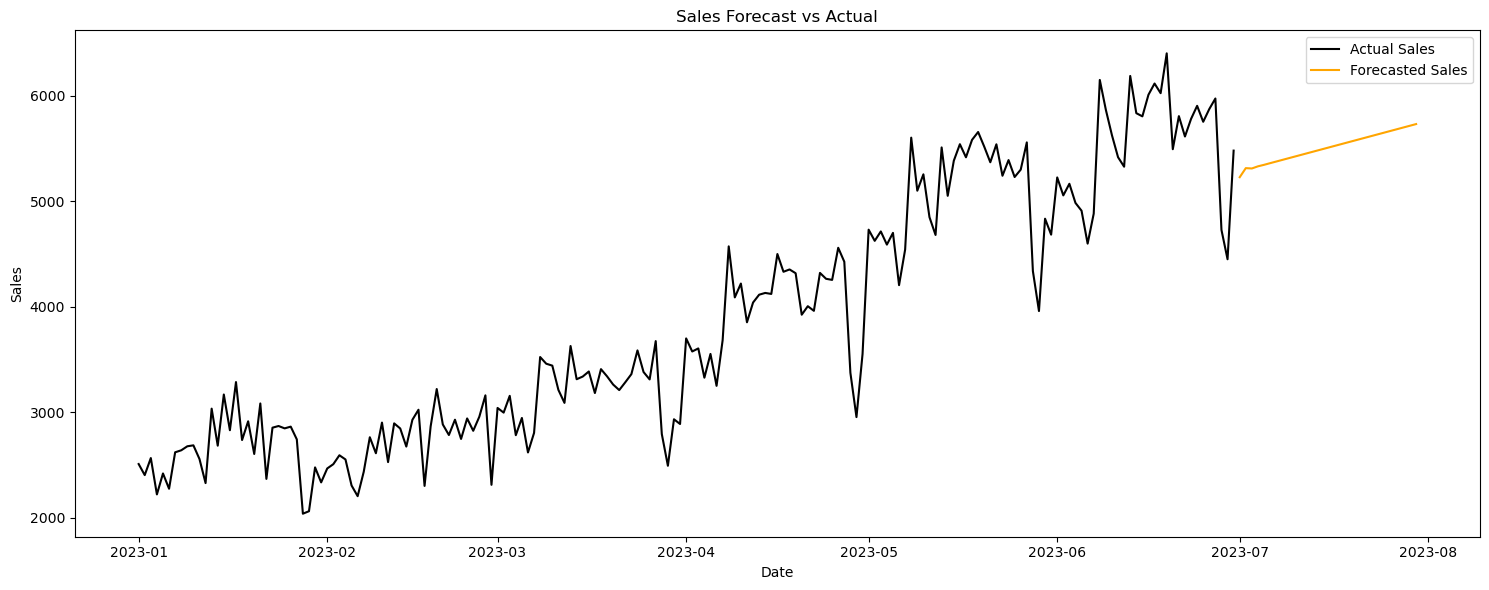

In [20]:
daily_sales= daily_sales.reset_index()

# Ensure forecast_original is a DataFrame with 'date' and 'sales' columns
forecast_df = pd.DataFrame({
    'date': forecast_original.index,
    'sales': forecast_original.values
})

# Now, plot both the daily_sales and forecast_df DataFrames

plt.figure(figsize= (15, 6))
sns.lineplot(data=daily_sales, x='date', y='sales', label='Actual Sales', color='black')
sns.lineplot(data=forecast_df, x='date', y='sales', label='Forecasted Sales', color='orange')

plt.title("Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
daily_sales.tail(30)

,date,sales,sales_diff
151,2023-06-01,5227.00,542.87
152,2023-06-02,5056.50,-170.50
153,2023-06-03,5166.65,110.15
154,2023-06-04,4985.15,-181.50
155,2023-06-05,4911.15,-74.00
156,2023-06-06,4598.90,-312.25
157,2023-06-07,4883.10,284.20
158,2023-06-08,6151.59,1268.49
159,2023-06-09,5867.16,-284.43
160,2023-06-10,5626.75,-240.41


In [22]:
forecast_df

,date,sales
0,2023-07-01,5229.050972
1,2023-07-02,5315.111790
2,2023-07-03,5311.943109
3,2023-07-04,5332.307390
4,2023-07-05,5346.465200
5,2023-07-06,5362.259875
6,2023-07-07,5377.622851
7,2023-07-08,5393.099681
8,2023-07-09,5408.546484
9,2023-07-10,5424.001206
